In [3]:
f1C11='so_subsets/1C-CS-81E41S160E64S.GPM.GMI.XCAL2016-C.20240901-S054432-E055430.059683.V07B.HDF5'
f2ADPR='so_subsets/2A-CS-81E41S160E64S.GPM.DPR.V9-20240130.20240901-S054546-E055514.059683.V07C.HDF5'
f2BCMB='so_subsets/2B-CS-81E41S160E64S.GPM.DPRGMI.CORRA2022.20240901-S054546-E055514.059683.V07C.HDF5'
import glob
fnames=sorted(glob.glob('so_subsets/*.059684*.HDF5'))
print(fnames)
f1C11=fnames[0]
f2ADPR=fnames[1]
fgprof=fnames[2]
f2BCMB=fnames[3]
import io_subs
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyresample import image, geometry
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,oe_wvp,oe_lwp,oe_iwp,oesfc_precip,stormTop,nearSfcPrecip,zeroDegAltitude,surfaceType=io_subs.readCMB(f2BCMB)
pType=(pType/1e7).astype(int)
lat_s1,lon_s1,tb_s1=io_subs.read1CGMI(f1C11)

input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling
wf = lambda r: 1 - r/20000.0
tb_s1_resampled = resample_custom(input_def, tb_s1[:,:,:], output_def, radius_of_influence=30000, neighbours=10, 
weight_funcs=[wf for k in range(9)], fill_value=None)

hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
a=[2,4,6,8]
import pickle


['so_subsets/1C-CS-81E41S160E64S.GPM.GMI.XCAL2016-C.20240901-S071747-E073028.059684.V07B.HDF5', 'so_subsets/2A-CS-81E41S160E64S.GPM.DPR.V9-20240130.20240901-S071900-E073029.059684.V07C.HDF5', 'so_subsets/2A-CS-81E41S160E64S.GPM.GMI.GPROF2021v1.20240901-S071747-E073028.059684.V07C.HDF5', 'so_subsets/2B-CS-81E41S160E64S.GPM.DPRGMI.CORRA2022.20240901-S071900-E073029.059684.V07C.HDF5']


/Users/mgrecu/miniforge3/lib/python3.12/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,


In [ ]:
#scripted_model = torch.jit.script(autoencoder)
#scripted_model.save("autoencoder.pt")
#import pickle
#d_scaler={'mean':tb_mean,'std':tb_std}
#pickle.dump(d_scaler,open('tb_scaler.pkl','wb'))
d_scaler=pickle.load(open('tb_scaler.pkl','rb'))
tb_mean=d_scaler['mean']
tb_std=d_scaler['std']
x_input=tb_s1_resampled[:ndpr//3,:,:].reshape(-1,9)
x_input=(x_input-tb_mean)/tb_std
import torch
scripted_model = torch.jit.load("autoencoder.pt")
tb_ecoded=scripted_model.encoder(torch.tensor(x_input).float())
tb_ecoded=tb_ecoded.detach().numpy()


component 00
[[ 1.         -0.63951903]
 [-0.63951903  1.        ]]
[[ 1.         -0.61682213]
 [-0.61682213  1.        ]]
component 01
[[1.         0.55665764]
 [0.55665764 1.        ]]
[[1.         0.80710543]
 [0.80710543 1.        ]]
component 02
[[ 1.         -0.09984386]
 [-0.09984386  1.        ]]
[[ 1.         -0.94436276]
 [-0.94436276  1.        ]]


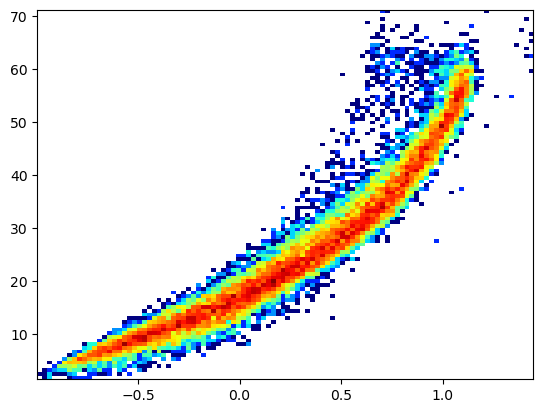

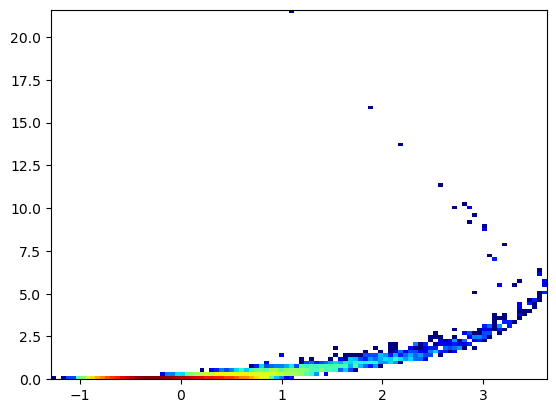

In [28]:
import netCDF4 as nc

with nc.Dataset("../precipDiagnostics/tb_all_freq_oceans.nc") as f:
    tb_all_freq = f.variables['tb_all_freq'][:]
    cldwp = f.variables['cldwp'][:]
    emiss = f.variables['emiss'][:]
    total_column_water_vapor = f.variables['total_column_water_vapor'][:]

x_sim_scaled=(tb_all_freq[:,:9]-tb_mean)/tb_std
x_sim_encoded=scripted_model.encoder(torch.tensor(x_sim_scaled).float())
x_sim_encoded=x_sim_encoded.detach().numpy()
for i in range(3):
    print("component %2.2i"%i)
    print(np.corrcoef(x_sim_encoded[:,i],cldwp))
    print(np.corrcoef(x_sim_encoded[:,i],total_column_water_vapor))
import matplotlib
h2d=plt.hist2d(-x_sim_encoded[:,2],total_column_water_vapor,bins=100,norm=matplotlib.colors.LogNorm(),cmap='jet')

plt.figure()
h2d=plt.hist2d(-x_sim_encoded[:,0],cldwp,bins=100,norm=matplotlib.colors.LogNorm(),cmap='jet')

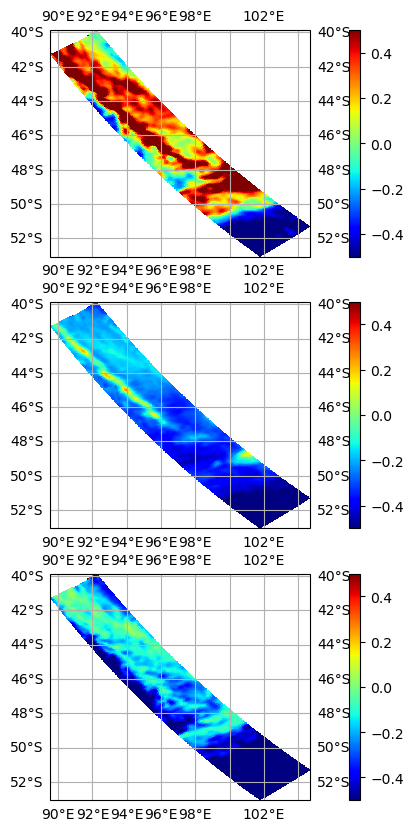

In [20]:

features=[]
for i in range(3):
    features.append(tb_ecoded[:,i].reshape(ndpr//3,49))
plt.figure(figsize=(10,10))
isign=[-1,1,-1]
for i in range(3):
    ax=plt.subplot(3,1,i+1,projection=ccrs.PlateCarree())
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],isign[i]*features[i],cmap='jet',vmin=-0.5,vmax=0.5)
    gl2=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    plt.colorbar()

In [4]:

#pickle.dump(knn,open('knncldwp_4.pklz','wb'))
#pickle.dump(knn_tpw,open('knntpw_4.pklz','wb'))
#knn=pickle.load(open('knncldwp_4.pklz','rb'))
#knn_tpw=pickle.load(open('knntpw_4.pklz','rb'))
ndpr=qv.shape[0]
#d_model={"tb_mean":tb_mean[:9],"tb_std":tb_std[:9],"total_column_water_vapor_mean":total_column_water_vapor.mean(),"total_column_water_vapor_std":total_column_water_vapor.std(),"cldwp_mean":cldwp.mean(),"cldwp_std":cldwp.std(),"model":knn}
import pickle
#with open('knn_gmi_s1_model.pkl', 'wb') as f:
#    pickle.dump(d_model, f)
d_model=pickle.load(open('knn_gmi_s1_model.pkl','rb'))
tb_mean=d_model["tb_mean"]
tb_std=d_model["tb_std"]
total_column_water_vapor_mean=d_model["total_column_water_vapor_mean"]
total_column_water_vapor_std=d_model["total_column_water_vapor_std"]
cldwp_mean=d_model["cldwp_mean"]
cldwp_std=d_model["cldwp_std"]
knn=d_model["model"]

x_input=tb_s1_resampled[:ndpr//3,:,:].reshape(-1,9)
x_input=(x_input-tb_mean)/tb_std
y_out=knn.predict(x_input)
total_column_water_vapor_predicted=y_out[:,0]*total_column_water_vapor_std+total_column_water_vapor_mean
cldwp_predicted=y_out[:,1]*cldwp_std+cldwp_mean


In [11]:
print(tb_mean)

[169.75692749023438 93.41938781738281 194.39111328125 128.16268920898438
 221.89120483398438 221.03565979003906 163.11097717285156
 267.5454406738281 240.66546630859375]


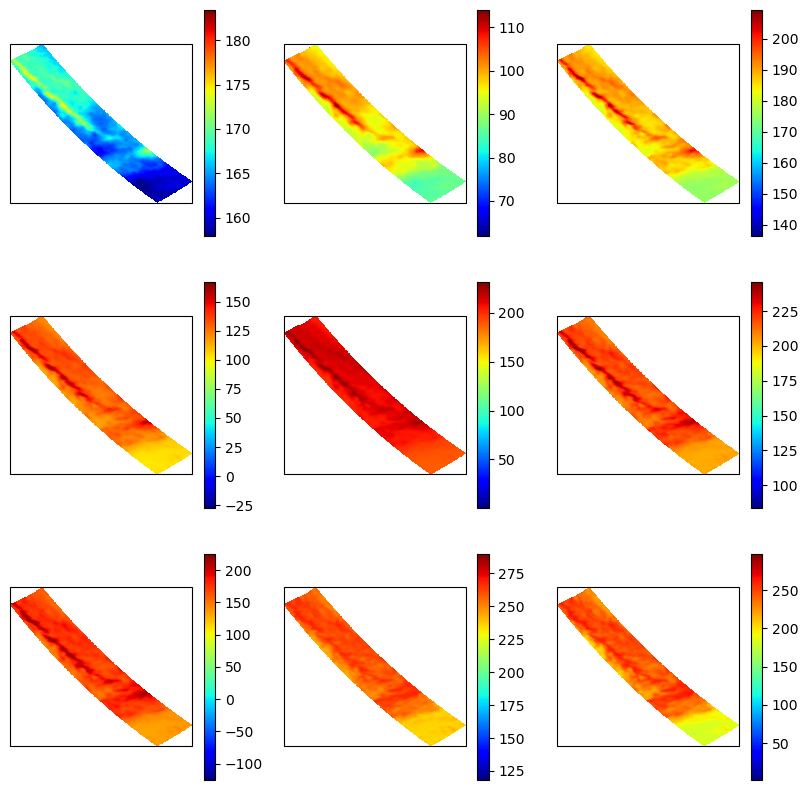

In [10]:
plt.figure(figsize=(10,10))

for i in range(9):
    ax=plt.subplot(3,3,i+1,projection=ccrs.PlateCarree())
    plt.pcolormesh(lon[:ndpr//3,:],lat[:ndpr//3,:],tb_s1_resampled[:ndpr//3,:,i],cmap='jet')
    plt.colorbar()

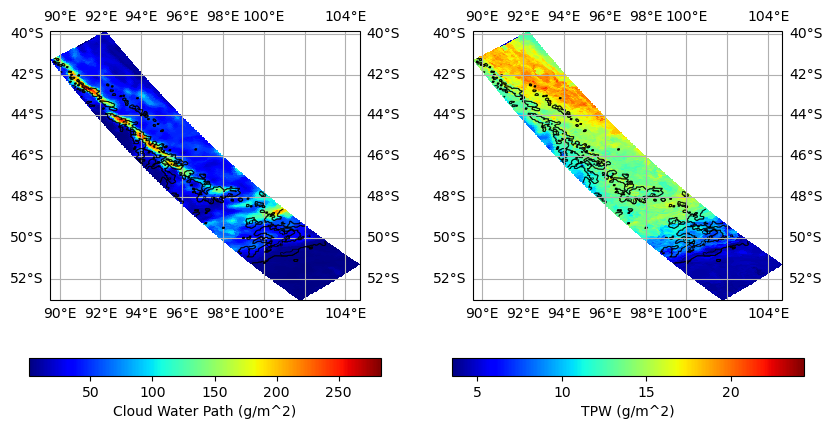

In [6]:
tpw_2d=total_column_water_vapor_predicted.reshape(ndpr//3,49)
cldwp_2d=cldwp_predicted.reshape(ndpr//3,49)
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

ax=plt.subplot(121,projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.right_labels=False
ax.top_labels=False
c=plt.pcolormesh(lon[:ndpr//3],lat[:ndpr//3],cldwp_2d*250,cmap='jet',transform=ccrs.PlateCarree())
plt.contour(lon[:ndpr//3],lat[:ndpr//3],pType[:ndpr//3,:],levels=[0.1,0.5,1],colors='black',transform=ccrs.PlateCarree(),linewidths=0.5)
plt.colorbar(c,orientation='horizontal',label='Cloud Water Path (g/m^2)')
#plt.figure()
ax2=plt.subplot(122,projection=ccrs.PlateCarree())
c2=plt.pcolormesh(lon[:ndpr//3],lat[:ndpr//3],tpw_2d,cmap='jet',transform=ccrs.PlateCarree())
plt.contour(lon[:ndpr//3],lat[:ndpr//3],pType[:ndpr//3,:],levels=[0.1,0.5,1],colors='black',transform=ccrs.PlateCarree(),linewidths=0.5)
gl2=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl2.xlabels_top = False
gl2.ylabels_right = False
#gl2.ylabel_artist.set_fontsize(8)
#ax2.draw_meridians(np.arange(-180,180,5),labels=[0,0,0,1])
#gl2.xlabels_top = False
plt.colorbar(c2,orientation='horizontal',label='TPW (g/m^2)')
plt.savefig('retrieved_cldwp_tpw_2_59684.png',dpi=300)
